In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [3]:
import glob

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install -q keras

In [7]:
import keras

In [6]:
from keras.layers import Input,Lambda,Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [8]:
IMAGE_SIZE = [224,224]

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [10]:
import glob
covid_path = glob.glob('/content/drive/MyDrive/COVID/*.png')

In [11]:
data = []
labels = []
for file in covid_path:
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224, 224))
  data.append(img)
  labels.append('covid')
  cv2.waitKey(0)
  cv2.destroyAllWindows()

In [12]:
import glob
normal_path = glob.glob('/content/drive/MyDrive/NORMAL/*.png')

for file in normal_path:
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224, 224))
  data.append(img)
  labels.append('normal')
  cv2.waitKey(0)
  cv2.destroyAllWindows()

In [ ]:
labels.count('pneumonia')

0

In [ ]:
data

[array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 52,  52,  52],
         [ 55,  55,  55],
         [ 57,  57,  57]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 49,  49,  49],
         [ 50,  50,  50],
         [ 51,  51,  51]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 46,  46,  46],
         [ 47,  47,  47],
         [ 48,  48,  48]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [199, 199, 199],
         [197, 197, 197],
         [194, 194, 194]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [205, 205, 205],
         [202, 202, 202],
         [200, 200, 200]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [230, 230, 230],
  

In [13]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [14]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
labels.shape

(2551, 2)

In [ ]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [15]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=2)

In [16]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
from tensorflow.keras.applications import VGG16
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 5
BS = 8
# compile our model
from tensorflow.keras.optimizers import Adam
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=1)

[INFO] training head...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


255/255 [==============================] - 1275s 5s/step - loss: 0.5012 - accuracy: 0.7658 - val_loss: 0.1219 - val_accuracy: 0.9706


In [28]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [29]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [30]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.99      0.95      0.97       240
      normal       0.96      0.99      0.97       271

    accuracy                           0.97       511
   macro avg       0.97      0.97      0.97       511
weighted avg       0.97      0.97      0.97       511



In [31]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[228  12]
 [  3 268]]
acc: 0.9706
sensitivity: 0.9500
specificity: 0.9889


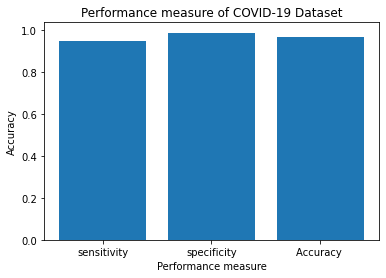

In [32]:
#y = np.array(sensitivity,specificity)
#x = np.array('sensitivity','specificity')
#plt.hist(x)
x = np.array(["sensitivity", "specificity", "Accuracy "])
y = np.array([sensitivity, specificity, acc])

plt.bar(x,y)

plt.title("Performance measure of COVID-19 Dataset")
plt.xlabel("Performance measure")
plt.ylabel("Accuracy")

plt.show()

In [33]:
# construct the head of the model that will be placed on top of the
# the base model
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)


In [34]:
headModel.shape


TensorShape([None, 512])

In [17]:
#from tensorflow.keras.applications import VGG16
#baseModel = VGG16(weights="imagenet", include_top=False,
#	input_tensor=Input(shape=(224, 224, 3)))
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
base_model_resnet = ResNet50(weights= "imagenet", include_top=False, input_shape= (224,224,3))

In [18]:
# construct the head of the model that will be placed on top of the
# the base model
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
headModel_resnet = base_model_resnet.output
headModel_resnet = AveragePooling2D(pool_size=(4, 4))(headModel_resnet)
headModel_resnet = Flatten(name="flatten")(headModel_resnet)
headModel_resnet = Dense(64, activation="relu")(headModel_resnet)
headModel_resnet = Dropout(0.5)(headModel_resnet)
headModel_resnet = Dense(2, activation="softmax")(headModel_resnet)

In [19]:
model_resnet = Model(inputs=base_model_resnet.input, outputs=headModel_resnet)

In [20]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in base_model_resnet.layers:
	layer.trainable = False

In [21]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 5
BS = 8
# compile our model
from tensorflow.keras.optimizers import Adam
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model_resnet.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [22]:
# train the head of the network
print("[INFO] training head...")
H = model_resnet.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=3)

[INFO] training head...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
255/255 [==============================] - 431s 2s/step - loss: 0.6997 - accuracy: 0.5876 - val_loss: 0.5600 - val_accuracy: 0.9041
Epoch 2/3
255/255 [==============================] - 347s 1s/step - loss: 0.5369 - accuracy: 0.7908
Epoch 3/3
255/255 [==============================] - 346s 1s/step - loss: 0.3819 - accuracy: 0.8829


In [23]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model_resnet.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [24]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [50]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.97      0.92      0.94       240
      normal       0.93      0.97      0.95       271

    accuracy                           0.95       511
   macro avg       0.95      0.95      0.95       511
weighted avg       0.95      0.95      0.95       511



In [25]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[227  13]
 [ 18 253]]
acc: 0.9393
sensitivity: 0.9458
specificity: 0.9336
